In [1]:
import numpy as np
import os
from os import listdir
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
from scipy import ndimage
from skimage.measure import regionprops
from skimage import io
from skimage.filters import threshold_otsu   # For finding the threshold for grayscale to binary conversion
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import pandas as pd
import numpy as np
from time import time
import keras

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
genuine_image_paths = "C:\\Users\\Iram\\Desktop\\Signature recognition\\sign_data\\all genuine"
forged_image_paths = "C:\\Users\\Iram\\Desktop\\Signature recognition\\sign_data\\all forged"
genuine_image_test ="C:\\Users\\Iram\\Desktop\\Signature recognition\\sign_data\\test\\all_genuine_test/"
forged_image_test ="C:\\Users\\Iram\\Desktop\\Signature recognition\\sign_data\\test\\all_forged_test/"

In [3]:
def rgbgrey(img):
    # Converts rgb to grayscale
    greyimg = np.zeros((img.shape[0], img.shape[1]))
    for row in range(len(img)):
        for col in range(len(img[row])):
            greyimg[row][col] = np.average(img[row][col])
    return greyimg

In [4]:
def greybin(img):
    # Converts grayscale to binary
    blur_radius = 0.8
    img = ndimage.gaussian_filter(img, blur_radius)  # to remove small components or noise
#     img = ndimage.binary_erosion(img).astype(img.dtype)
    thres = threshold_otsu(img)
    binimg = img > thres
    binimg = np.logical_not(binimg)
    return binimg

In [5]:
def preproc(path, img=None, display=True):
    if img is None:
        img = mpimg.imread(path)
    if display:
        plt.imshow(img)
        plt.show()
    grey = rgbgrey(img) #rgb to grey
    if display:
        plt.imshow(grey, cmap = matplotlib.cm.Greys_r)
        plt.show()
    binimg = greybin(grey) #grey to binary
    if display:
        plt.imshow(binimg, cmap = matplotlib.cm.Greys_r)
        plt.show()
    r, c = np.where(binimg==1)
    # Now we will make a bounding box with the boundary as the position of pixels on extreme.
    # Thus we will get a cropped image with only the signature part.
    signimg = binimg[r.min(): r.max(), c.min(): c.max()]
    if display:
        plt.imshow(signimg, cmap = matplotlib.cm.Greys_r)
        plt.show()
    return signimg

In [6]:
def Ratio(img):
    a = 0
    for row in range(len(img)):
        for col in range(len(img[0])):
            if img[row][col]==True:
                a = a+1
    total = img.shape[0] * img.shape[1]
    return a/total

In [7]:
def Centroid(img):
    numOfWhites = 0
    a = np.array([0,0])
    for row in range(len(img)):
        for col in range(len(img[0])):
            if img[row][col]==True:
                b = np.array([row,col])
                a = np.add(a,b)
                numOfWhites += 1
    rowcols = np.array([img.shape[0], img.shape[1]])
    centroid = a/numOfWhites
    centroid = centroid/rowcols
    return centroid[0], centroid[1]

In [8]:
def EccentricitySolidity(img):
    r = regionprops(img.astype("int8"))
    return r[0].eccentricity, r[0].solidity

In [9]:
def SkewKurtosis(img):
    h,w = img.shape
    x = range(w)  # cols value
    y = range(h)  # rows value
    #calculate projections along the x and y axes
    xp = np.sum(img,axis=0)
    yp = np.sum(img,axis=1)
    #centroid
    cx = np.sum(x*xp)/np.sum(xp)
    cy = np.sum(y*yp)/np.sum(yp)
    #standard deviation
    x2 = (x-cx)**2
    y2 = (y-cy)**2
    sx = np.sqrt(np.sum(x2*xp)/np.sum(img))
    sy = np.sqrt(np.sum(y2*yp)/np.sum(img))
    
    #skewness
    x3 = (x-cx)**3
    y3 = (y-cy)**3
    skewx = np.sum(xp*x3)/(np.sum(img) * sx**3)
    skewy = np.sum(yp*y3)/(np.sum(img) * sy**3)

    #Kurtosis
    x4 = (x-cx)**4
    y4 = (y-cy)**4
    # 3 is subtracted to calculate relative to the normal distribution
    kurtx = np.sum(xp*x4)/(np.sum(img) * sx**4) - 3
    kurty = np.sum(yp*y4)/(np.sum(img) * sy**4) - 3

    return (skewx , skewy), (kurtx, kurty)

In [10]:
def getFeatures(path, img=None, display=False):
    if img is None:
        img = mpimg.imread(path)
    img = preproc(path, display=display)
    ratio = Ratio(img)
    centroid = Centroid(img)
    eccentricity, solidity = EccentricitySolidity(img)
    skewness, kurtosis = SkewKurtosis(img)
    retVal = (ratio, centroid, eccentricity, solidity, skewness, kurtosis)
    return retVal

In [11]:
def getCSVFeatures(path, img=None, display=False):
    if img is None:
        img = mpimg.imread(path)
    temp = getFeatures(path, display=display)
    features = (temp[0], temp[1][0], temp[1][1], temp[2], temp[3], temp[4][0], temp[4][1], temp[5][0], temp[5][1])
    return features

In [12]:
def makeCSV():
    if not(os.path.exists('C:\\Users\\Iram\\Desktop\\Signature recognition\\sign_data\\Features')):
        os.mkdir('C:\\Users\\Iram\\Desktop\\Signature recognition\\sign_data\\Features')
        print('New folder "Features" created')
    if not(os.path.exists('C:\\Users\\Iram\\Desktop\\Signature recognition\\sign_data\\Features/Training')):
        os.mkdir('C:\\Users\\Iram\\Desktop\\Signature recognition\\sign_data\\Features/Training')
        print('New folder "Features/Training" created')
    if not(os.path.exists('C:\\Users\\Iram\\Desktop\\Signature recognition\\sign_data\\Features/Testing')):
        os.mkdir('C:\\Users\\Iram\\Desktop\\Signature recognition\\sign_data\\Features/Testing')
        print('New folder "Features/Testing" created')
    # genuine signatures path
    gpath = genuine_image_paths
    gpath_test = genuine_image_test
    # forged signatures path
    fpath = forged_image_paths
    fpath_test = forged_image_test
    for person in range(1,7):
        per = ('00'+str(person))[-3:]
        print('Saving features for person id-',per)
        
        with open('C:\\Users\\Iram\\Desktop\\Signature recognition\\sign_data\\Features\\Training/training_'+per+'.csv', 'w') as handle:
            handle.write('ratio,cent_y,cent_x,eccentricity,solidity,skew_x,skew_y,kurt_x,kurt_y,output\n')
            # Training set
            for i in range(1,25):
                source = os.path.join(gpath, per+per+'_00'+str(i)+'.png')
                features = getCSVFeatures(path=source)
                handle.write(','.join(map(str, features))+',1\n')
            for i in range(1,13):
                source = os.path.join(fpath, '091'+per+'_00'+str(i)+'.png')
                features = getCSVFeatures(path=source)
                handle.write(','.join(map(str, features))+',0\n')
        
        with open('C:\\Users\\Iram\\Desktop\\Signature recognition\\sign_data\\Features\\Testing/testing_'+per+'.csv', 'w') as handle:
            handle.write('ratio,cent_y,cent_x,eccentricity,solidity,skew_x,skew_y,kurt_x,kurt_y,output\n')
            # Testing set
            for i in range(1, 13):
                source = os.path.join(gpath_test, per+per+'_00'+str(i)+'.png')
                features = getCSVFeatures(path=source)
                handle.write(','.join(map(str, features))+',1\n')
            for i in range(1,13):
                source = os.path.join(fpath_test, '091'+per+'_00'+str(i)+'.png')
                features = getCSVFeatures(path=source)
                handle.write(','.join(map(str, features))+',0\n')


# Call the function with your image paths
makeCSV()

Saving features for person id- 001
Saving features for person id- 002
Saving features for person id- 003
Saving features for person id- 004
Saving features for person id- 005
Saving features for person id- 006


In [13]:
def testing(path):
    feature = getCSVFeatures(path)
    if not(os.path.exists('C:\\Users\\Iram\\Desktop\\Signature recognition\\sign_data/TestFeatures')):
        os.mkdir('C:\\Users\\Iram\\Desktop\\Signature recognition\\sign_data/TestFeatures')
    with open('C:\\Users\\Iram\\Desktop\\Signature recognition\\sign_data\\TestFeatures/testcsv.csv', 'w') as handle:
        handle.write('ratio,cent_y,cent_x,eccentricity,solidity,skew_x,skew_y,kurt_x,kurt_y\n')
        handle.write(','.join(map(str, feature))+'\n')

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from time import time

n_input = 9
train_person_id = input("Enter person's id: ")
test_image_path = input("Enter path of the signature image: ")
train_path = 'C:\\Users\\Iram\\Desktop\\Signature recognition\\sign_data\\Features\\Training/training_'+train_person_id+'.csv'
test_path = 'C:\\Users\\Iram\\Desktop\\Signature recognition\\sign_data\\Features\\Testing/testing_'+train_person_id+'.csv'

def readCSV(train_path, test_path, type2=False):
    # Reading train data
    df_train = pd.read_csv(train_path)
    train_input = df_train.iloc[:, :n_input].values.astype(np.float32)  # Extracting first n_input columns
    corr_train = df_train.iloc[:, -1].values  # Assuming the label is in the last column

    # Reading test data
    df_test = pd.read_csv(test_path)
    test_input = df_test.iloc[:, :n_input].values.astype(np.float32)  # Extracting first n_input columns

    if not type2:
        corr_test = df_test.iloc[:, -1].values  # Assuming the label is in the last column
        return train_input, corr_train, test_input, corr_test
    else:
        return train_input, corr_train, test_input

# Parameters
learning_rate = 0.001
training_epochs = 1000
display_step = 1

# Initialize SVM Classifier
svm_classifier = SVC(kernel='linear')  # You can experiment with different kernels

# Read data
train_input, corr_train, test_input, corr_test = readCSV(train_path, test_path)

# Preprocess Data
scaler = StandardScaler()
train_input = scaler.fit_transform(train_input)
test_input = scaler.transform(test_input)

# Train SVM Model
svm_classifier.fit(train_input, corr_train)

# Make Predictions
prediction = svm_classifier.predict(test_input)

# Output Results
if prediction[0] == 1:
    print("Genuine Image")
else:
    print("Forged Image")


Enter person's id: 001
Enter path of the signature image: C:\\Users\\Iram\\Desktop\\Signature recognition\\sign_data\\test\\all_forged_test\\091001_002.PNG
Forged Image


Person 1: EER=0.7499999999996647, EAR=0.5833333333333334, Accuracy=0.4166666666666667
Person 2: EER=0.7500000000002555, EAR=0.5, Accuracy=0.5
Person 3: EER=0.0, EAR=0.125, Accuracy=0.875
Person 4: EER=0.24999999999930084, EAR=0.2916666666666667, Accuracy=0.75
Person 5: EER=0.24999999999913575, EAR=0.41666666666666663, Accuracy=0.6666666666666666
Person 6: EER=0.4166666666666666, EAR=0.375, Accuracy=0.6666666666666666


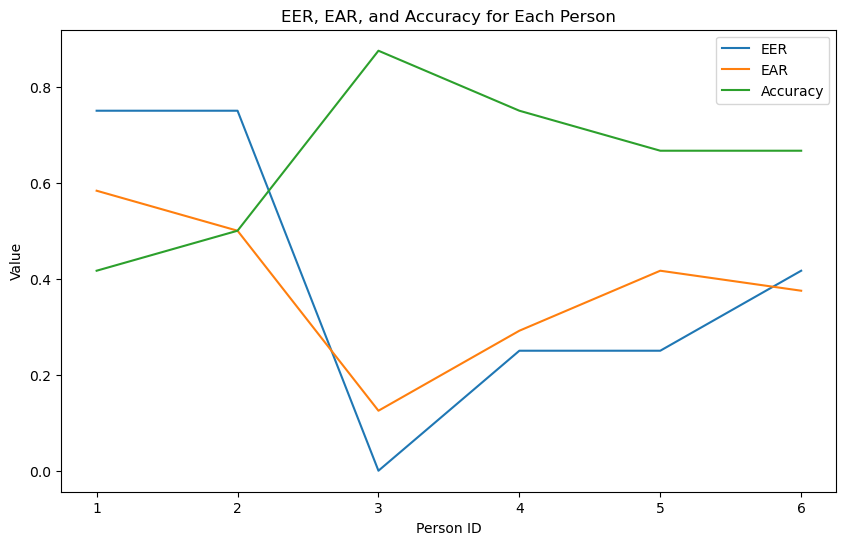

In [15]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.metrics import accuracy_score

def getCSVFeatures(path):
    # Assuming getCSVFeatures is a function to extract features from an image
    pass

def readCSV(train_path, test_path):
    # Reading train data
    df_train = pd.read_csv(train_path)
    train_input = df_train.iloc[:, :-1].values.astype(np.float32)  # Extracting features
    corr_train = df_train.iloc[:, -1].values  # Assuming the label is in the last column

    # Reading test data
    df_test = pd.read_csv(test_path)
    test_input = df_test.iloc[:, :-1].values.astype(np.float32)  # Extracting features
    corr_test = df_test.iloc[:, -1].values  # Assuming the label is in the last column

    return train_input, corr_train, test_input, corr_test

def calculate_eer(predictions, labels):
    fpr, tpr, thresholds = roc_curve(labels, predictions)
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    return eer

def calculate_ear(predictions, labels, threshold=0.5):
    positive_mask = (predictions >= threshold)
    negative_mask = ~positive_mask
    far = np.mean(positive_mask[labels == 0])
    frr = np.mean(negative_mask[labels == 1])
    ear = (far + frr) / 2
    return ear

# Path to your CSV files
train_folder = 'C:\\Users\\Iram\\Desktop\\Signature recognition\\sign_data\\Features\\Training'
test_folder = 'C:\\Users\\Iram\\Desktop\\Signature recognition\\sign_data\\Features\\Testing'

eer_list = []
ear_list = []
accuracy_list = []

for person_id in range(1, 7):
    train_path = os.path.join(train_folder, 'training_' + ('00' + str(person_id))[-3:] + '.csv')
    test_path = os.path.join(test_folder, 'testing_' + ('00' + str(person_id))[-3:] + '.csv')

    # Read data
    train_input, corr_train, test_input, corr_test = readCSV(train_path, test_path)

    # Preprocess Data
    scaler = StandardScaler()
    train_input = scaler.fit_transform(train_input)
    test_input = scaler.transform(test_input)

    # Initialize SVM Classifier
    svm_classifier = SVC(kernel='linear')

    # Train SVM Model
    svm_classifier.fit(train_input, corr_train)

    # Make Predictions
    predictions = svm_classifier.decision_function(test_input)

    # Calculate EER
    eer = calculate_eer(predictions, corr_test)
    eer_list.append(eer)

    # Calculate EAR
    ear = calculate_ear(predictions, corr_test)
    ear_list.append(ear)

    # Calculate Accuracy
    accuracy = accuracy_score(corr_test, predictions > 0)
    accuracy_list.append(accuracy)

    print(f"Person {person_id}: EER={eer}, EAR={ear}, Accuracy={accuracy}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, 7), eer_list, label='EER')
plt.plot(range(1, 7), ear_list, label='EAR')
plt.plot(range(1, 7), accuracy_list, label='Accuracy')
plt.xlabel('Person ID')
plt.ylabel('Value')
plt.title('EER, EAR, and Accuracy for Each Person')
plt.legend()
plt.show()
